#  Evoked responses: Stimulus-evoked changes in spectral parameters
<p>Figures: epoch based analysis, spectrum difference, shematic difference, histogram difference, spectrogram
<p>
<p>created: September 18, 2024
<p>last modified: September 23, 2024


## Set-up

In [1]:
# auto-reload
%load_ext autoreload
%autoreload 2

In [2]:
# general
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import gridspec

# custom
import sys
sys.path.append("../../code")
from paths import PROJECT_PATH, EXTERNAL_PATH
from info import SESSIONS, FS, TOTAL_CHANS, EPOCH_TIMES, N_ARRAYS, N_CHANS
from settings import SPECPARAM_SETTINGS, FREQS, BANDS
from plots import plot_schematic, plot_erp, plot_spectra_2conditions, plot_psd_diff
from utils import compute_erp
from tfr_utils import plot_evoked_tfr, preprocess_tfr

In [3]:
# set plotting style
plt.style.use('../../mpl_styles/sfn_2024.mplstyle')

# baseline time window for ERP computation
T_BASELINE = (-0.3, 0) # baseline period for ERP calculation (s)

### Functions

### Create output directory

In [4]:
dir_out = f"{EXTERNAL_PATH}/figures/sfn_2024"
if not os.path.exists(dir_out):
    os.makedirs(dir_out)

#### load data

In [5]:
# load spectral parameters
params = pd.read_csv(fR"{EXTERNAL_PATH}\data\results\lfp_spectral_params.csv", index_col=0)

## Main

### Epoched based analysis and spectrum difference 

>> scripts/plotting/plot_spectra.py

### Schematic difference

In [6]:
# # plot and save in external drive
# for i_session, session in enumerate(SESSIONS):
#     # set odmlpath
#     odml_path = f"{EXTERNAL_PATH}/V1_v4_1024_electrode_resting_state_data/data/{session}/metadata_{session}.odml"

#     # create directory for figure output
#     dir_figs = f"{EXTERNAL_PATH}/figures/params_schematic/{session}"
#     if not os.path.exists(dir_figs):
#         os.makedirs(dir_figs)


#     # get data for session
#     df_session = params[params['session']==session]
#     df_pre = df_session[df_session['epoch'] == 'pre']
#     df_post = df_session[df_session['epoch'] == 'post']

#     # look through features
#     for var in ['offset', 'exponent', 'knee', 'r_squared']:
#         # setting limits for colorbar
#         all_values = np.append(df_pre[f"{var}"], df_post[f"{var}"])
#         maxli = np.nanmax(all_values)
#         minli = np.nanmin(all_values)

#         # change in var
#         diff = df_post[var].values - df_pre[var].values
#         plot_schematic(diff, odml_path, norm_type="centered", title=f"session: {session}", 
#                         label=f"difference in {var}", vmin=np.nanmin(diff), vmax=np.nanmax(diff), 
#                         fname_out=f"{dir_figs}/{session}_{var}_diff.png")


### Histogram difference

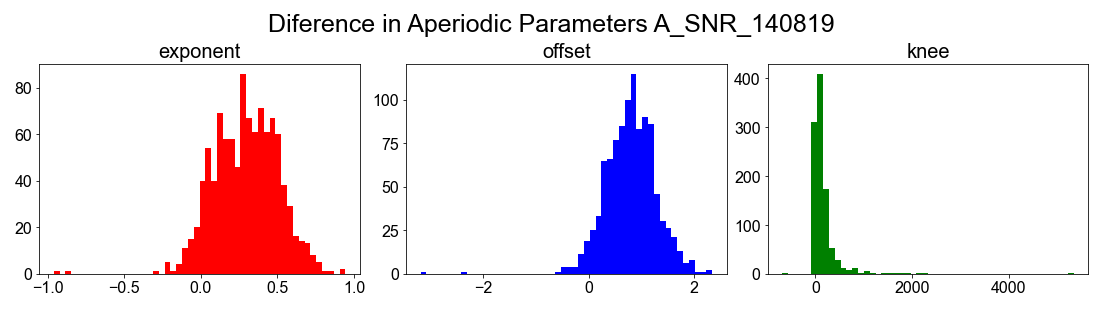

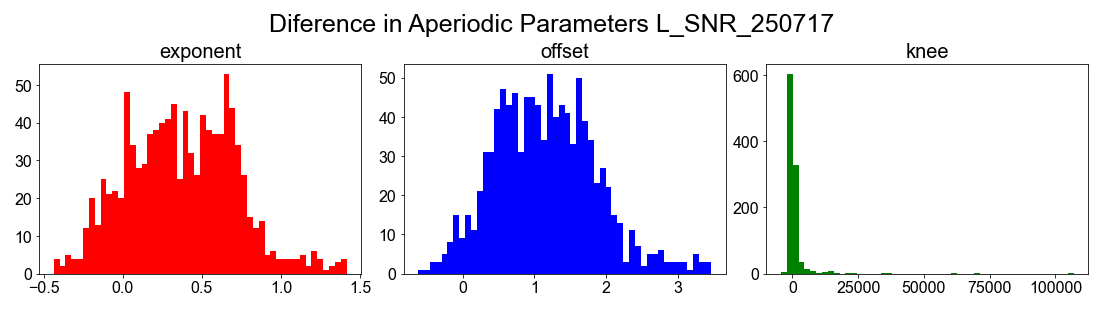

In [7]:
# plot params histogram for difference
for session in SESSIONS:
    df_pre = params[(params['session']  == session) & (params['epoch'] == 'pre')]
    df_post = params[(params['session']  == session) & (params['epoch'] == 'post')]

    fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(15,4))

    #exp
    exponent = df_post['exponent'].values - df_pre['exponent'].values 
    ax1.hist(exponent, bins=50, color='red')
    ax1.set_title('exponent')

    #off
    offset = df_post['offset'].values - df_pre['offset'].values 
    ax2.hist(offset, bins=50, color='blue')
    ax2.set_title('offset')

    #knee
    knee = df_post['knee'].values - df_pre['knee'].values
    ax3.hist(knee, bins=50, color='green')
    ax3.set_title('knee')

    fig.suptitle(f'Diference in Aperiodic Parameters {session}')
    fig.savefig(f'{EXTERNAL_PATH}/figures/params_schematic/{session}/params_diff_histogram.png')

### Spectrogram

In [8]:
# load example spectrogram
dir_input = f"{EXTERNAL_PATH}/data/lfp/lfp_tfr/sessions"
files = os.listdir(dir_input)
data_in = np.load(f"{dir_input}/{files[1]}")

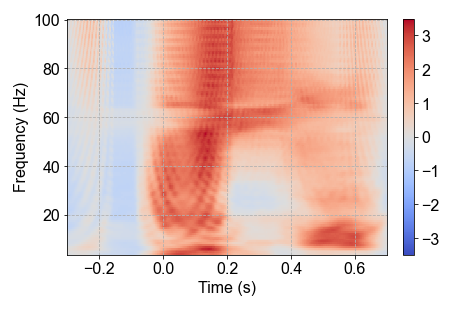

In [9]:
# plot
tfr, time = preprocess_tfr(data_in['spectrogram'], data_in['time'])
plot_evoked_tfr(tfr, data_in['freq'], time)

### **Possibly: ERP

In [10]:
# load example LFP epochs
dir_input = f"{EXTERNAL_PATH}/data/lfp/lfp_epochs/{SESSIONS[1]}"
fname_in = fr"{dir_input}\NSP1_array1_LFP.npy"
lfp = np.load(fname_in)

print(f"LFP Shape: \t{lfp.shape} (trials x channels x samples)")

LFP Shape: 	(66, 64, 500) (trials x channels x samples)


In [11]:
# init time-vector
time = np.arange(EPOCH_TIMES[0], EPOCH_TIMES[1], 1/FS)

# compute ERP - subtract baseline, average over trials
erp = compute_erp(lfp, time, t_baseline=T_BASELINE)
print(f"ERP Shape: \t{erp.shape} (channels x samples)")

ERP Shape: 	(64, 500) (channels x samples)


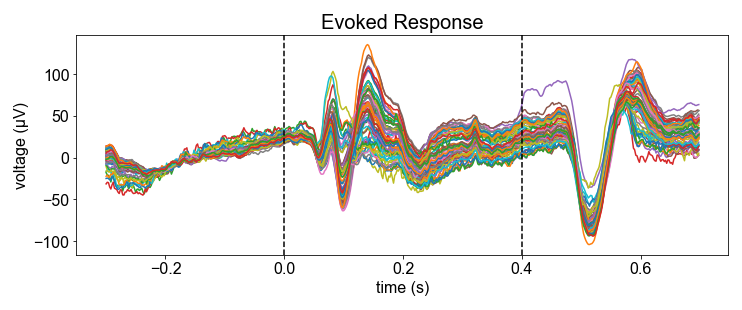

In [12]:
# plot example erp
fig, ax = plt.subplots(figsize=(10, 4))
plot_erp(erp, time, ax=ax, annotate_times=[0,0.4])

(16, 500)


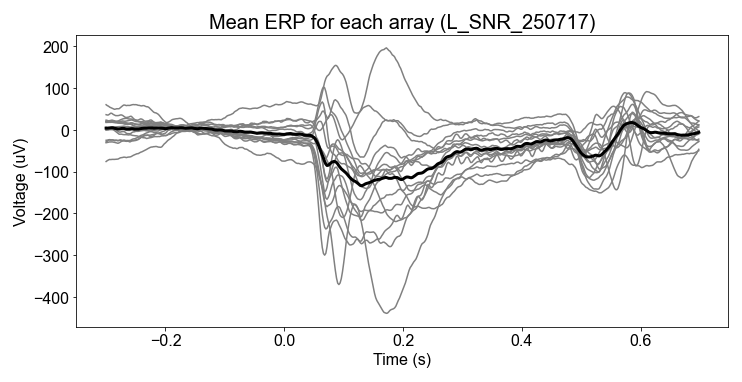

In [13]:
# plotting the mean for each array in a session
dir_input = fr"{EXTERNAL_PATH}\data\lfp\lfp_epochs\{SESSIONS[1]}"

# create empty array for erp mean
erps = np.zeros([N_ARRAYS, N_CHANS, int(np.diff(EPOCH_TIMES)*FS)])

# loop through arrays
for ii in range(N_ARRAYS):
    idx_array = ii + 1
    idx_nsp = (idx_array+1) // 2

    # load data and compute erp
    fname_in = fr"{dir_input}\NSP{idx_nsp}_array{idx_array}_LFP.npy"
    lfp = np.load(fname_in)
    erps[ii] = compute_erp(lfp, time, t_baseline=T_BASELINE)

# compute mean of all arrays
erp_array = np.nanmean(erps, axis=1)
print(erp_array.shape)

# plot mean of all arrays
fig, ax = plt.subplots(figsize=(10,5))
ax.plot(time, erp_array.T, color='grey')
ax.plot(time, np.nanmean(erp_array, axis=0), color='k', linewidth=3)
ax.set_title(f"Mean ERP for each array ({SESSIONS[1]})")
ax.set_xlabel("Time (s)")
ax.set_ylabel("Voltage (uV)")
plt.show()

### Proposed layout / gridspec template

In [14]:
# set session
session = SESSIONS[1]

warning[None:5:<{http://www.w3.org/1999/xsl/transform}stylesheet>]: Invalid element <{http://www.w3.org/1999/xsl/transform}stylesheet> inside <odML> tag
 (line 5)
warning[None:5:<{http://www.w3.org/1999/xsl/transform}stylesheet>]: Invalid element <{http://www.w3.org/1999/xsl/transform}stylesheet> in odML document section <odML>  (line 5)
warning[None:5:<{http://www.w3.org/1999/xsl/transform}stylesheet>]: Invalid element <{http://www.w3.org/1999/xsl/transform}stylesheet> inside <odML> tag
 (line 5)
warning[None:5:<{http://www.w3.org/1999/xsl/transform}stylesheet>]: Invalid element <{http://www.w3.org/1999/xsl/transform}stylesheet> in odML document section <odML>  (line 5)


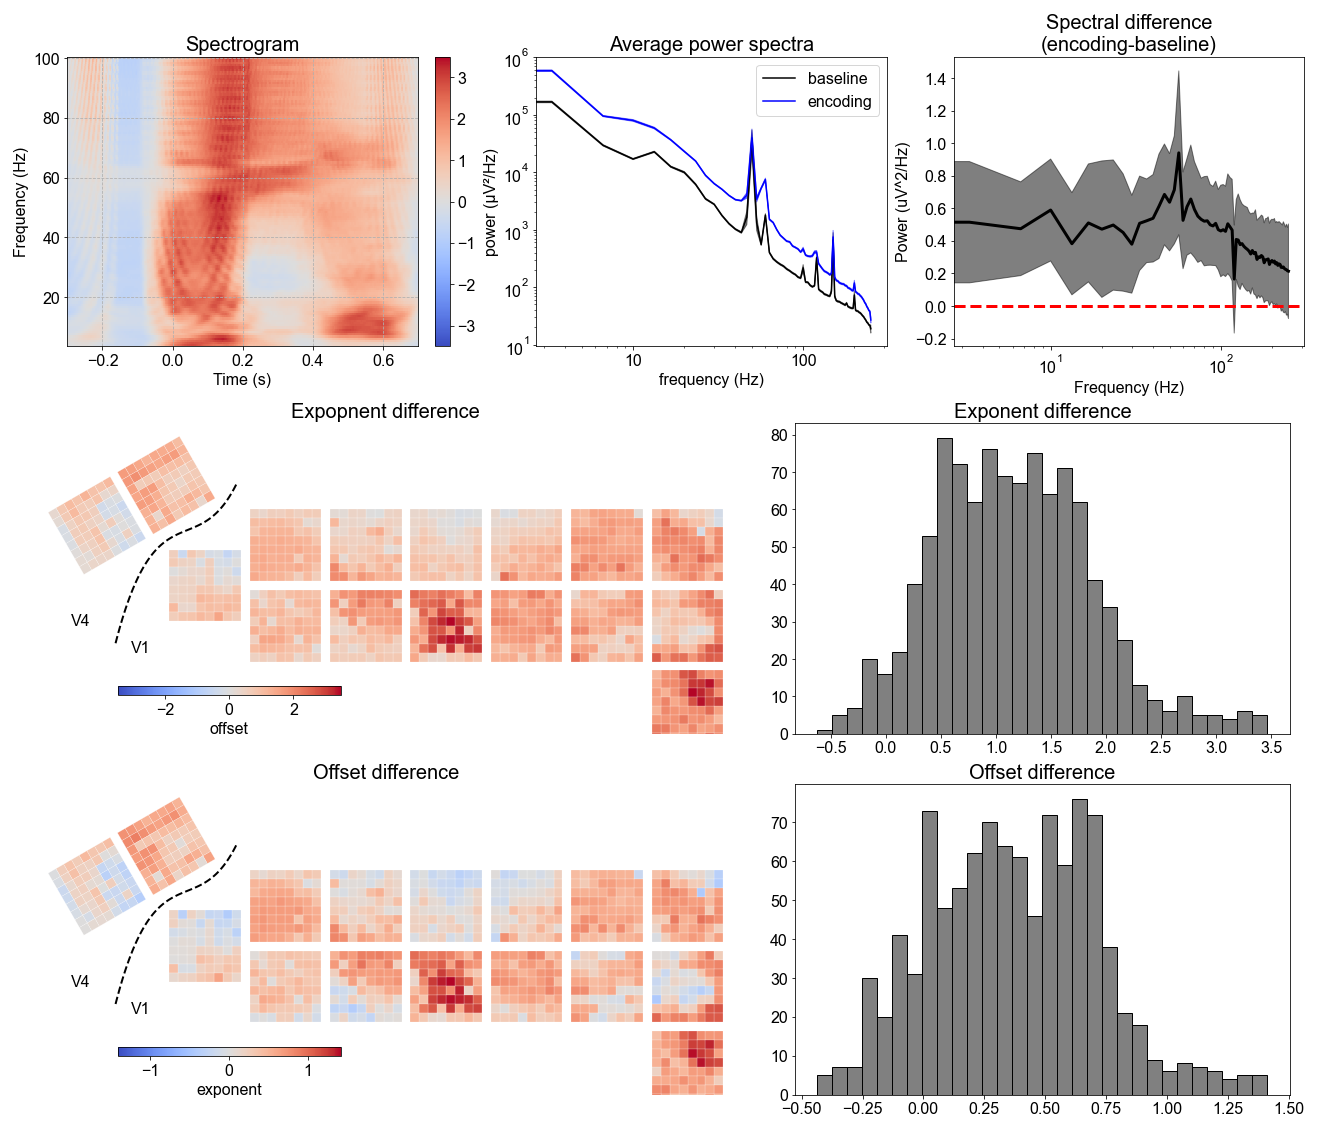

In [18]:
# create figure and gridspec
fig = plt.figure(figsize=[18, 15.4], constrained_layout=True)
spec = gridspec.GridSpec(figure=fig, ncols=2, nrows=3, width_ratios=[1,2/3], 
                         height_ratios=[1.25,1,1])

# create subplots (second and third row)
ax_d = fig.add_subplot(spec[1,0])
ax_e = fig.add_subplot(spec[1,1])
ax_f = fig.add_subplot(spec[2,0])
ax_g = fig.add_subplot(spec[2,1])

# create nested gridspec in first row
spec_a = spec[0,:].subgridspec(ncols=3, nrows=1, width_ratios=[1,1,1])
ax_a = fig.add_subplot(spec_a[0,0])
ax_b = fig.add_subplot(spec_a[0,1])
ax_c = fig.add_subplot(spec_a[0,2])

# set titles
ax_a.set_title("Spectrogram")
ax_b.set_title("Average power spectra")
# ax_c.set_title("Spectral difference") # set below after plotting
ax_d.set_title("Expopnent difference")
ax_e.set_title("Exponent difference")
ax_f.set_title("Offset difference")
ax_g.set_title("Offset difference")

# plot spectrogram ------------
data_in = np.load(f"{EXTERNAL_PATH}\data\lfp\lfp_tfr\sessions\L_SNR_250717_lfp.npz")
tfr, time = preprocess_tfr(data_in['spectrogram'], data_in['time'])
plot_evoked_tfr(tfr, data_in['freq'], time, ax=ax_a, fig=fig)

# plot average power spectra & spectral difference ------------
data = np.load(f"{EXTERNAL_PATH}/data/lfp/lfp_psd/{session}_spectra.npz")
spectra_pre = np.nanmean(data['spectra_pre'], axis=0)
spectra_post = np.nanmean(data['spectra_post'], axis=0)
psd_diff = np.log10(spectra_post) - np.log10(spectra_pre)
plot_spectra_2conditions(spectra_pre, spectra_post, 
                                    data['freq'], ax=ax_b)
plot_psd_diff(data['freq'], psd_diff, ax=ax_c)
ax_c.set_title("Spectral difference\n(encoding - baseline)")


# plot subplot d-g: schematic and histogram for offset and exponent ------------
odml_path = f"{EXTERNAL_PATH}/V1_v4_1024_electrode_resting_state_data/data/{session}/metadata_{session}.odml"

# loop through offset and exponent
for var, ax_schem, ax_hist in zip(['offset', 'exponent'], 
                                  [ax_d, ax_f], 
                                  [ax_e, ax_g]):
    # get data for session, epoch, and variable
    pre = params.loc[(params['session']==session) & 
                        (params['epoch']=='pre'), var]
    
    post = params.loc[(params['session']==session) & 
                        (params['epoch']=='post'), var]
    diff = post.values - pre.values
    
    # plot schematic
    plot_schematic(diff, odml_path, norm_type="centered", label=var, ax=ax_schem)

    # plot histogram
    ax_hist.hist(diff, bins=30, color='gray', edgecolor='k')

# save figure
plt.savefig(f'{dir_out}/panel_6.png')
